# KOSMI 예제를 Keras 로 바꿔보기 

google drive mount 

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

In [3]:
ls gdrive/My\ Drive

'Colab Notebooks'/   dataset/   foo.txt   Keras/


In [4]:
import PIL 
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [6]:
# 랜덤시드 고정시키기
np.random.seed(2)

# 데이터셋 생성하기 
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'gdrive/My Drive/dataset/KOSMI_tutorial/retinopathy_dataset_resize_gray/train',
        target_size=(128, 128),
        batch_size=64,
        class_mode='binary') # 카테고리로 하면 모델 학습시 에러, 이진 분류면 꼭 binary 로 해야하는듯 

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'gdrive/My Drive/dataset/KOSMI_tutorial/retinopathy_dataset_resize_gray/test',
        target_size=(128, 128),    
        batch_size=64,
        class_mode='binary')

Found 1230 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


In [0]:
# 모델 구성 
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid')) # 0, 1 의 이진분류 

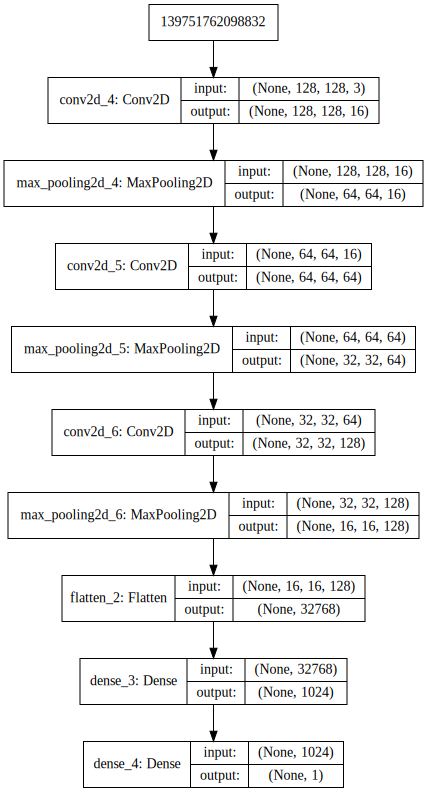

In [13]:
# 모델 시각화 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# 모델 학습과정 설정 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 조기종료함수 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

In [15]:
# 모델 학습시키기 
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=20,  # train sample 1230, batch size 64
        epochs=30,
        validation_data=test_generator,
        validation_steps=5, # test sample 292, batch size 64
        #callbacks=[early_stopping]
        )  

Epoch 1/30
20/20 [==============================] - 62s 3s/step - loss: 0.8201 - acc: 0.4876 - val_loss: 0.6930 - val_acc: 0.5616
Epoch 2/30
20/20 [==============================] - 58s 3s/step - loss: 0.6925 - acc: 0.5188 - val_loss: 0.6937 - val_acc: 0.4966
Epoch 3/30
20/20 [==============================] - 58s 3s/step - loss: 0.6936 - acc: 0.5341 - val_loss: 0.7152 - val_acc: 0.4897
Epoch 4/30
20/20 [==============================] - 58s 3s/step - loss: 0.6912 - acc: 0.5460 - val_loss: 0.6876 - val_acc: 0.5651
Epoch 5/30
20/20 [==============================] - 58s 3s/step - loss: 0.6854 - acc: 0.5482 - val_loss: 0.7199 - val_acc: 0.5514
Epoch 6/30
20/20 [==============================] - 58s 3s/step - loss: 0.6852 - acc: 0.5632 - val_loss: 0.6890 - val_acc: 0.5479
Epoch 7/30
20/20 [==============================] - 58s 3s/step - loss: 0.6727 - acc: 0.5942 - val_loss: 0.7047 - val_acc: 0.5308
Epoch 8/30
20/20 [==============================] - 59s 3s/step - loss: 0.6563 - acc: 0.62

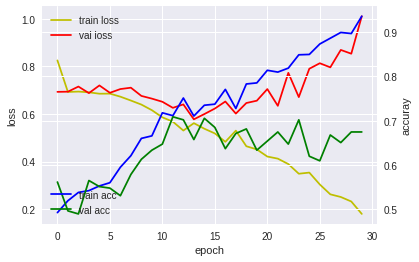

In [16]:
# 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [17]:
# 모델 평가하기 
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
acc: 66.44%


In [18]:
# 모델 사용하기 
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Predict --
{'0': 0, '1': 1}
[[0.047]
 [0.492]
 [0.225]
 [0.017]
 [0.649]
 [0.769]
 [0.999]
 [0.543]
 [0.005]
 [0.997]
 [0.983]
 [0.963]
 [0.810]
 [0.000]
 [0.940]
 [0.106]
 [0.038]
 [0.472]
 [1.000]
 [0.936]
 [0.677]
 [0.949]
 [0.136]
 [0.395]
 [0.732]
 [0.996]
 [0.136]
 [0.886]
 [0.987]
 [0.669]
 [0.062]
 [0.069]
 [0.989]
 [0.859]
 [0.007]
 [0.363]
 [0.098]
 [0.889]
 [0.326]
 [0.173]
 [0.986]
 [0.001]
 [0.987]
 [0.995]
 [0.303]
 [0.002]
 [0.025]
 [0.000]
 [0.019]
 [0.892]
 [0.721]
 [0.689]
 [0.979]
 [0.041]
 [0.925]
 [0.988]
 [0.213]
 [0.020]
 [1.000]
 [0.471]
 [0.014]
 [0.999]
 [0.224]
 [0.575]
 [0.727]
 [0.945]
 [0.998]
 [0.000]
 [0.957]
 [0.717]
 [0.967]
 [0.934]
 [0.973]
 [0.957]
 [0.247]
 [0.944]
 [0.077]
 [0.081]
 [0.748]
 [0.596]
 [0.739]
 [0.999]
 [1.000]
 [0.953]
 [0.882]
 [0.995]
 [0.731]
 [0.629]
 [0.019]
 [0.994]
 [0.909]
 [0.999]
 [0.825]
 [0.201]
 [0.001]
 [0.727]
 [0.032]
 [0.006]
 [0.304]
 [0.015]
 [0.857]
 [0.925]
 [0.155]
 [0.402]
 [0.171]
 [0.947]
 [0.669]
 [0.08